# Full Analysis of Political and Mitigation Data

#### Package Imports and importing data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import networkx as nx
import numpy.linalg as LA
from tqdm.notebook import trange
import ipywidgets as widgets
import pickle
import csv

# from ICC_Change_Point import *

import matplotlib.pylab as pl
import matplotlib as mpl
from matplotlib import cm
poli_norm_color = mpl.colors.Normalize(vmin=-4, vmax=4)

from scipy.stats.stats import pearsonr
from scipy.optimize import quadratic_assignment
from QAP import QAP
from tqdm.notebook import trange

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['lines.solid_capstyle'] = 'butt'

ModuleNotFoundError: No module named 'utils'

In [ ]:
poli_parties = pd.read_csv('./data/politics.csv')

gov_response = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v3/oxford-government-response.csv')
gov_response.columns = gov_response.columns.str.replace('_' , ' ')

emergency_df = pd.read_csv('./data/lawatlas-emergency-declarations.csv')
emergency_df.columns = emergency_df.columns.str.replace('lawatlas_' , '')
emergency_df.columns = emergency_df.columns.str.replace('_' , ' ')

# partition for states
emergency_df['real_date'] = pd.to_datetime(emergency_df["date"]).dt.strftime("%Y-%m-%d")
gov_response['real_date'] = pd.to_datetime(gov_response["date"]).dt.strftime("%Y-%m-%d")
public_health_df = gov_response

state_dfs = {}
for i in range(51):
    df = public_health_df[public_health_df['location key'] == emergency_df.iloc[164*i,1]]
    state_dfs[emergency_df.iloc[164*i,1]] = df
del state_dfs['US_DC']

geo_data = pd.read_csv('./data/state_adj.csv', header = None)

In [3]:
geo_data
geo_key = geo_data.iloc[:,0]
geo_adj = np.zeros([50,50])
for i, s1 in enumerate(geo_key):
    for s2 in geo_data.iloc[i,1:]:
        j = np.where(s2 == geo_key)[0]
        geo_adj[i,j] = 1

In [4]:
file_name = './data/us_case_data_23_2_7.pkl'
States = ['Alaska',
          'Alabama',
          'Arkansas',
          'Arizona',          
          'California',
          'Colorado',
          'Connecticut',
          'Delaware',
          'Florida',
          'Georgia',
          'Hawaii',
          'Iowa',
          'Idaho',
          'Illinois',
          'Indiana',          
          'Kansas',
          'Kentucky',
          'Louisiana',
          'Massachusetts',
          'Maryland',
          'Maine',          
          'Michigan',
          'Minnesota',
          'Missouri',
          'Mississippi',    
          'Montana',
          'North Carolina',
          'North Dakota',
          'Nebraska',
          'New Hampshire',
          'New Jersey',
          'New Mexico',
          'Nevada',
          'New York',
          'Ohio',
          'Oklahoma',
          'Oregon',
          'Pennsylvania',
          'Rhode Island',
          'South Carolina',
          'South Dakota',
          'Tennessee',
          'Texas',
          'Utah',
          'Virginia',
          'Vermont',
          'Washington',
          'Wisconsin',
          'West Virginia',
          'Wyoming']

with open(file_name, 'rb') as f:
    us_case_data = pickle.load(f)

state_pop = [733391,
             5024279,
             3011524,
             7151502,
             39538223,
             5773714,
             3605944,
             989948,
             21538187,
             10711908,
             1455271,
             3190369,
             1839106,
             12812508,
             6785528,
             2937880,
             4505836,
             4657757,
             7029917,
             6177224,
             1362359,
             10077331,
             5706494,
             6154913,
             2961279,
             1084225,
             10439388,
             779094,
             1961504,
             1377529,
             9288994,
             2117522,
             3104614,
             20201249,
             11799448,
             3959353,
             4237256,
             13002700,
             1097379,
             5118425,
             886667,
             6910840,
             29145505,
             3271616,
             8631393,
             643077,
             7705281,
             5893718,
             1793716,
             576851]
file_name = './data/us_case_data_23_2_7.pkl'

with open(file_name, 'rb') as f:
    us_case_data = pickle.load(f)  
dates = us_case_data['Dates'][:800]  
length = len(dates)+9
time = np.arange(length)

#### Extract Mitigation Values and Normalize for each state

In [5]:
measures = [2,3,4,5,6,7,8,11,19]
mitigation_list = []
for state in state_dfs:
    mitigation_vector = np.empty([len(state_dfs[state]), 9])
    for index, row in enumerate(state_dfs[state].to_numpy()):
        mitigation_vector[index] = np.array(row[measures]).T
    mitigation_list.append(mitigation_vector)
    
min_length = np.amin([len(i) for i in mitigation_list])
for index, _ in enumerate(mitigation_list):
    mitigation_list[index] = mitigation_list[index][:length-9]
mitigation_array = np.array(mitigation_list)
mitigation_array = np.nan_to_num(mitigation_array,0)
for strat in range(mitigation_array.shape[-1]):
    mitigation_array[:,:,strat] /= np.amax(mitigation_array[:,:,strat])
    
mitigation_change = np.zeros([mitigation_array.shape[1],50])
for t in range(7,mitigation_array.shape[1]):
    mitigation_change[t] = np.sign(LA.norm(mitigation_array[:,t,:], axis = -1) - LA.norm(mitigation_array[:,t-7,:], axis = -1))
    
CDC_guidance = gov_response.iloc[np.where(gov_response['location key'] == 'US')[0],:]
CDC_ts = []
for i in range(len(CDC_guidance)):
    cdc = np.array(CDC_guidance.iloc[i,measures])
    CDC_ts.append(cdc)
CDC_ts = np.row_stack(CDC_ts).astype('float')

inc_array = np.empty([50,len(dates)])
for i, state in enumerate(States):
    case_data = us_case_data[state][:length+9]  
    CP = Change_Point_Analysis(case_data)
    CP.find_inc(time, 1, smooth = True, avg_size = 12)
    inc_array[i] = CP.inc_smooth/state_pop[i]*100000

#### Calculate Mitigation Matrices with connections for various measures

In [6]:
mitigation_difference = np.zeros([mitigation_array.shape[1],50])
mitigation_strength = np.zeros([mitigation_array.shape[1], 50])
mean_list = []
var_list = []
mitigation_networks = []
mitigation_networks_1sd = []
mitigation_networks_binary = []
mitigation_networks_change = []
mitigation_networks_full = []
inc_networks = []


for t in trange(mitigation_array.shape[1]):
    mean = np.mean(LA.norm(mitigation_array[:,t,:], axis = -1))
    var = np.var(LA.norm(mitigation_array[:,t,:], axis = -1))
    mean_list.append(mean)
    var_list.append(var)
    mitigation_difference[t] = mean - LA.norm(mitigation_array[:,t,:], axis = -1)
    
    mitigation_d = mitigation_difference[t]
    mitigation_distance_1sd = np.zeros([50,50])
    mitigation_distance_binary = np.zeros([50,50])
    inc_distance = np.zeros([50,50])
    mitigation_distance_full = np.zeros([50,50])
    mitigation_strength[t] = LA.norm(mitigation_array[:, t, :], axis = -1)
    sd = np.sqrt(np.var(mitigation_difference[t]))
    mean_inc = np.mean(inc_array[:,t])
    for state_index in range(50):
        for state_2_index in range(50):
            if np.abs(mitigation_difference[t,state_index]) >= sd and np.abs(mitigation_difference[t,state_2_index]) >= sd and mitigation_difference[t,state_2_index]*mitigation_difference[t,state_index] > 0 and state_index != state_2_index:
                mitigation_distance_1sd[state_index, state_2_index] = 1
            if np.abs(mitigation_difference[t,state_index] - mitigation_difference[t,state_2_index]) < 0.05*mean and state_index != state_2_index:
                mitigation_distance_binary[state_index,state_2_index] = 1
            if np.abs(inc_array[state_index,t] - inc_array[state_2_index,t]) < 0.05*mean_inc:
                inc_distance[state_index, state_2_index] = 1
            mitigation_distance_full[state_index, state_2_index] = LA.norm(mitigation_array[state_index, t, :] - mitigation_array[state_2_index,t,:])
            
    mitigation_networks_full.append(mitigation_distance_full)
    mitigation_networks_1sd.append(mitigation_distance_1sd)
    mitigation_networks_binary.append(mitigation_distance_binary)
    inc_networks.append(inc_distance)
    
for t in range(0,mitigation_array.shape[1], 7):
    mitigation_distance_change = np.zeros([50,50])
    for state_index in range(50):
        for state_2_index in range(50):    
            if mitigation_change[t,state_index]*mitigation_change[t,state_2_index] > 0 and mitigation_difference[t,state_index]*mitigation_change[t,state_index] < 0 and state_index != state_2_index:
                mitigation_distance_change[state_index,state_2_index] = 1
    # print(np.sum(mitigation_distance_change))
    mitigation_networks_change.append(mitigation_distance_change)

  0%|          | 0/797 [00:00<?, ?it/s]

 #### Create a Matrix that represents change in mitigation strength

#### Create and Visualize Political Likeness Matrix

(-11.844161393976096, 9.40760324136749, -4.257436221369454, 3.6398578521209033)

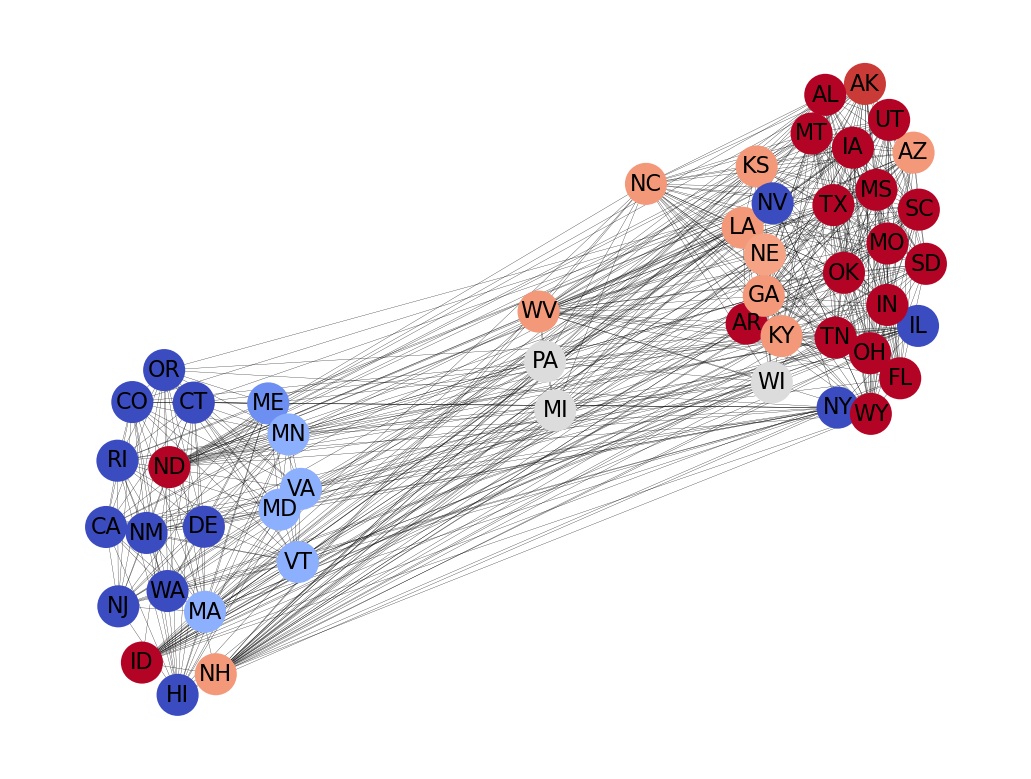

In [7]:
party_strength = np.zeros(50)
for state in range(50):
    for i in range(2,9,2):
        if poli_parties.iloc[state,i] == 1:
            party_strength[state] += 1
        elif poli_parties.iloc[state,i] == 0:
            party_strength[state] -= 1
        else:
            party_strength[state] += poli_parties.iloc[state,i]
            
party_strength = -party_strength
    
poli_adj = np.zeros([50,50])
poli_distance = np.zeros([50,50])
for state_index in range(50):
    for state_2_index in range(state_index, 50):
        dist = LA.norm(party_strength[state_index] - party_strength[state_2_index])
        if dist <= 2 and state_index != state_2_index:
        # if poli_parties.iloc[state_index,-1] == poli_parties.iloc[state_2_index,-1] and state_index != state_2_index:
            poli_adj[state_index, state_2_index] = 1
        poli_distance[state_index, state_2_index] = dist
poli_adj = poli_adj + poli_adj.T

for i in range(poli_adj.shape[0]):
    poli_adj[i,i] = 0
    
# G = nx.from_numpy_matrix(poli_adj)
# # G = nx.from_numpy_matrix(geo_adj)

# nodePos = nx.spring_layout(G, k =.75, iterations = 150)
# with open('Node_Positions.pkl', 'rb') as f:
#     nodePos = pickle.load(f)
# nx.draw_networkx(G, node_size = 200, width = .1, node_color = cm.coolwarm(poli_norm_color(-party_strength)), labels = poli_parties.iloc[:,0], with_labels = True, pos = nodePos, font_size = 8)
# plt.axis('off')

## Analysis

### Non-Graphical Correlation

In [10]:
party_mitigation_correlation = []
party_change_correlation = []
gov_mitigation_correlation = []
leg_mitigation_correlation = []
sen_mitigation_correlation = []
elec_mitigation_correlation = []

for t in trange(mitigation_array.shape[1]):
    party_mitigation_correlation.append(np.corrcoef(party_strength, mitigation_strength[t])[0,1])
    party_change_correlation.append(np.corrcoef(party_strength, mitigation_change[t])[0,1])
    gov_mitigation_correlation.append(np.corrcoef(-poli_parties.iloc[:,-1], mitigation_strength[t])[0,1])
    leg_mitigation_correlation.append(np.corrcoef(-poli_parties.iloc[:,4], mitigation_strength[t])[0,1])
    sen_mitigation_correlation.append(np.corrcoef(-poli_parties.iloc[:,2], mitigation_strength[t])[0,1])
    elec_mitigation_correlation.append(np.corrcoef(-poli_parties.iloc[:,6], mitigation_strength[t])[0,1])

  0%|          | 0/797 [00:00<?, ?it/s]

In [11]:
total_norm = np.empty([mitigation_array[:,:,-2].shape[0], 797])
rep_norm = 0
total_rep = 0
dem_norm = 0
total_dem = 0
rep_list = []
dem_list = []

for index in range(mitigation_array[:,:,-2].shape[0]):
    norm = LA.norm(mitigation_array[index,:,:], axis = -1)
    if party_strength[index] < 0:
        rep_norm += norm
        total_rep += 1
        rep_list.append(index)
    else:
        dem_norm += norm
        total_dem += 1
        dem_list.append(index)
    total_norm[index, :] = norm
        
rep_mean = rep_norm/total_rep
dem_mean = dem_norm/total_dem
rep_var = np.var(total_norm[rep_list], axis = 0)
dem_var = np.var(total_norm[dem_list], axis = 0)

(0.0, 0.1)

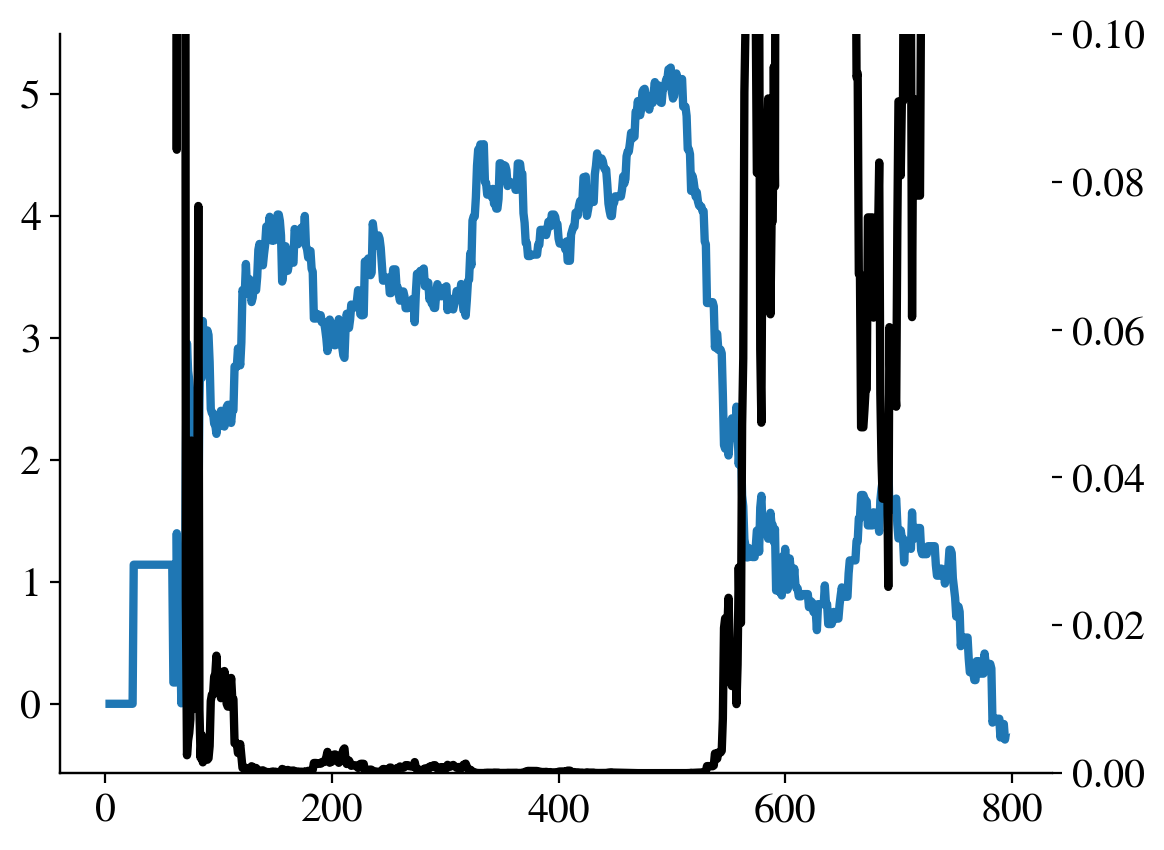

In [12]:
z = []
p = []
for t in range(mitigation_array.shape[1]):
    z.append((dem_mean[t]-rep_mean[t])/np.sqrt(var_list[t])/np.sqrt(1/total_rep + 1/total_dem))
    p.append(stats.t.sf(np.abs(z[-1]), total_rep+total_dem-2))
z = np.nan_to_num(np.array(z))
fig, ax = plt.subplots()
ax.plot(z)
ax1 = ax.twinx()
ax1.plot(p,'k')
ax1.set_ylim(0,0.1)

[]

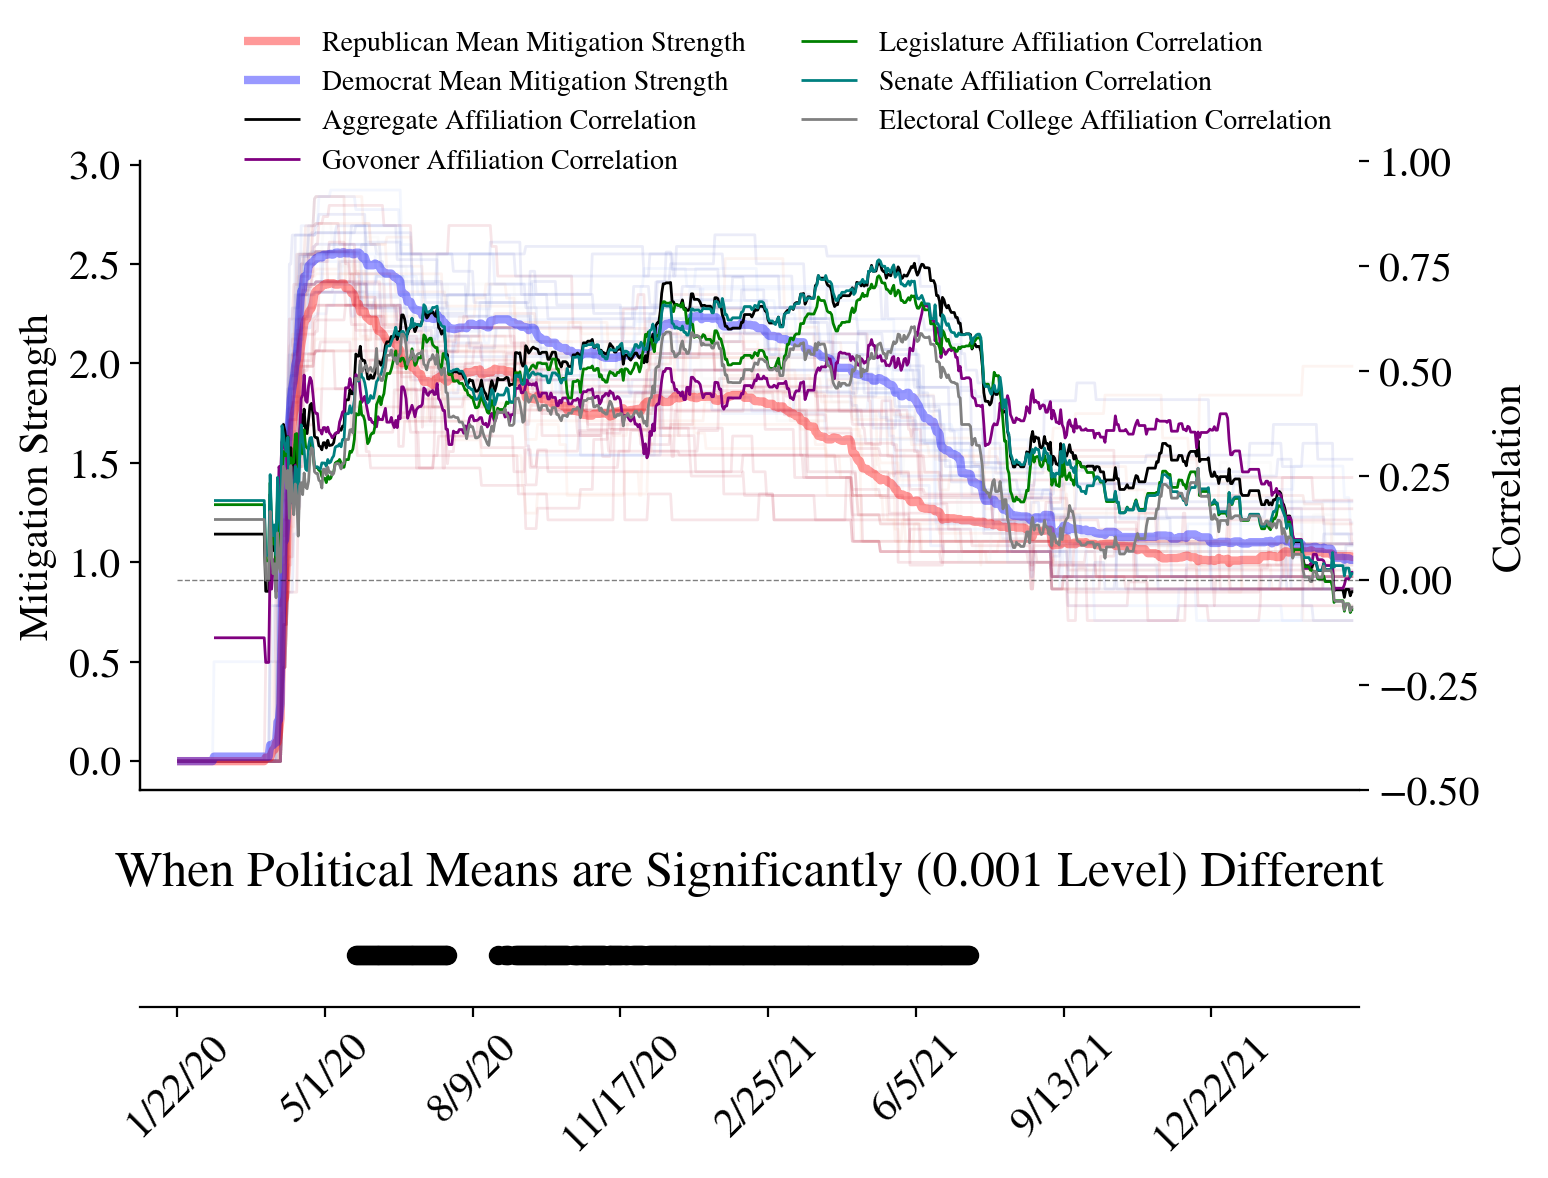

In [41]:
fig, (ax, ax2) = plt.subplots(2,1, figsize = (7,5), gridspec_kw={'height_ratios': [6, 1]})
fig.tight_layout(pad = 1)
for index in range(mitigation_array[:,:,-2].shape[0]):
    z = ax.plot(LA.norm(mitigation_array[index,:,:], axis = -1), linewidth = 1, alpha = 0.1, color = cm.coolwarm(poli_norm_color(-party_strength[index])))
    
ax.plot(rep_norm/total_rep, 'r', label = 'Republican Mean Mitigation Strength', alpha = 0.4)
ax.plot(dem_norm/total_dem, 'b', label = 'Democrat Mean Mitigation Strength', alpha = 0.4)

ax1 = ax.twinx()
ax1.plot(party_mitigation_correlation, 'k', lw = 1, label = 'Aggregate Affiliation Correlation')
ax1.plot(gov_mitigation_correlation,color = 'purple', lw = 1, label = 'Govoner Affiliation Correlation')
ax1.plot(leg_mitigation_correlation, color = 'green', lw = 1, label = 'Legislature Affiliation Correlation')
ax1.plot(sen_mitigation_correlation, color = 'teal', lw = 1, label = 'Senate Affiliation Correlation')
ax1.plot(elec_mitigation_correlation, 'grey', lw = 1, label = 'Electoral College Affiliation Correlation')
ax1.set_ylim(-0.5,1)

rep_mean = rep_norm/total_rep
dem_mean = dem_norm/total_dem
rep_var = np.var(total_norm[rep_list], axis = 0)
dem_var = np.var(total_norm[dem_list], axis = 0)
ax.set_xticks([])
ax2.set_xticks(time[:-9][::100], dates[::100], rotation = 45)
ax.set_ylabel('Mitigation Strength')
ax1.set_ylabel('Correlation')
# fig.legend(fontsize = 10, loc = 9, ncol = 3, bbox_to_anchor = (0.53,1.1))
fig.legend(fontsize = 10, ncol = 2, bbox_to_anchor = (0.95,1.1))
# fig.suptitle('Mitigation Strength Correlation with Various Measures of Political Affilation', y = 1.16)

p_where = np.where(np.array(p) < 0.001)[0]
ax2.scatter(p_where,np.zeros(len(p_where)), color ='k')
ax2.spines.left.set_color('white')
ax2.set_title('When Political Means are Significantly (0.001 Level) Different')
ax1.plot([0,975], [0,0], 'k--', alpha = 0.5, lw = 0.5)
ax.set_xlim(-25,800)
ax2.set_xlim(-25,800)
ax2.set_yticks([])

In [14]:
print(np.amax(elec_mitigation_correlation[70:545]) , np.nanmean(elec_mitigation_correlation[70:545]), np.nanmean(elec_mitigation_correlation[545:]) )

0.6058557111847006 0.45532482171448285 0.11643368893316623


In [15]:
dates[536]

'7/11/21'

### Graph Correlation Analysis

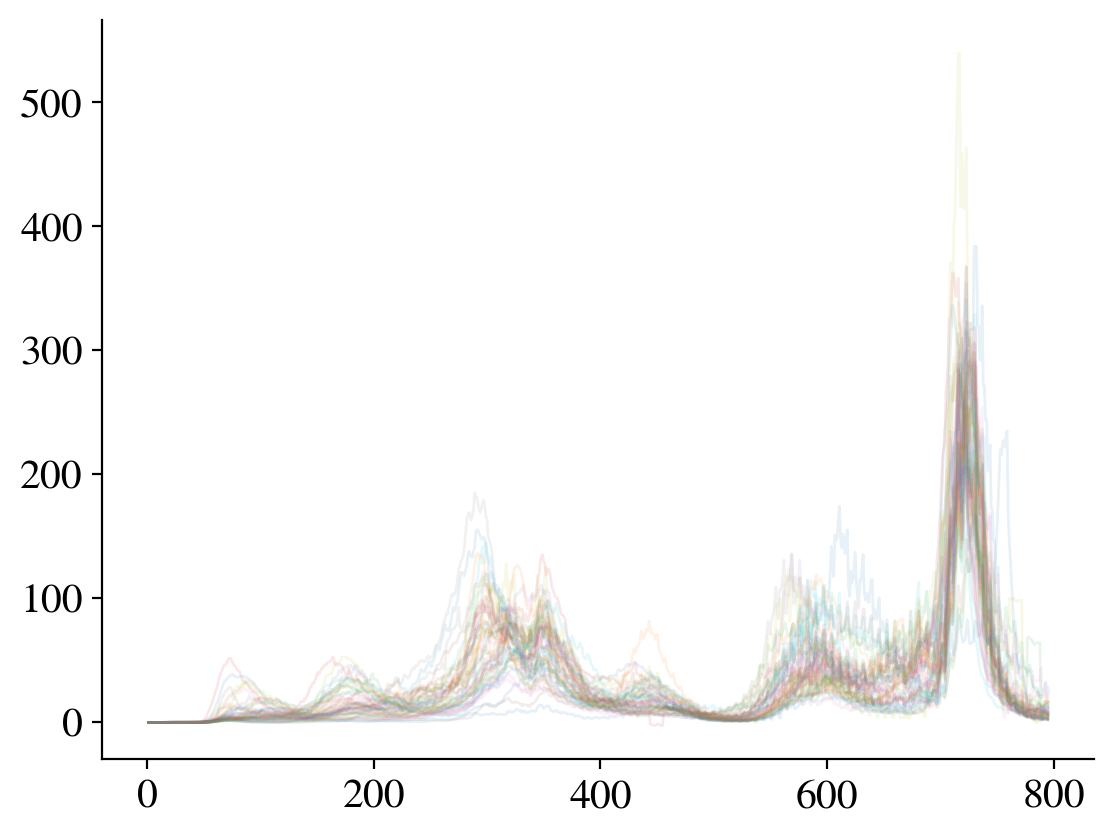

In [16]:
fig, ax = plt.subplots()
ax.plot(inc_array.T, lw = 1, alpha = 0.1)

#### QAP

In [17]:
corr_1sd = []
corr_binary = []
corr_full = []
corr_geo = []
corr_change = []
corr_inc = []

for t in trange(mitigation_array.shape[1]):
    qap_1sd = QAP(X=poli_adj.astype('float'), Y=mitigation_networks_1sd[t],npermutations = -1)
    qap_1sd.qap()
    corr_1sd.append(qap_1sd.beta)
    
    qap_binary = QAP(X=poli_adj.astype('float'), Y=mitigation_networks_binary[t],npermutations = -1)
    qap_binary.qap()
    corr_binary.append(qap_binary.beta)
    
    qap_full = QAP(X=poli_distance.astype('float'), Y=mitigation_networks_full[t],npermutations = -1)
    qap_full.qap()
    corr_full.append(qap_full.beta)
    
    qap_geo = QAP(X=geo_adj.astype('float'), Y=mitigation_networks_binary[t],npermutations = -1)
    qap_geo.qap()
    corr_geo.append(qap_geo.beta)
    
    qap_inc = QAP(X=inc_networks[t].astype('float'), Y=mitigation_networks_binary[t],npermutations = -1)
    qap_inc.qap()
    corr_inc.append(qap_inc.beta)
    
for t in range(0,int(mitigation_array.shape[1]/7)+1):
    qap_change = QAP(X=poli_adj.astype('float'), Y=mitigation_networks_change[t],npermutations = -1)
    qap_change.qap()
    corr_change.append(qap_change.beta)
    
corr_1sd = np.row_stack(corr_1sd)
corr_binary = np.row_stack(corr_binary)
corr_full = np.row_stack(corr_full)
corr_geo = np.row_stack(corr_geo)
corr_change = np.row_stack(corr_change)
corr_inc = np.row_stack(corr_inc)

  0%|          | 0/797 [00:00<?, ?it/s]

In [18]:
np.sum(inc_networks[200])

170.0

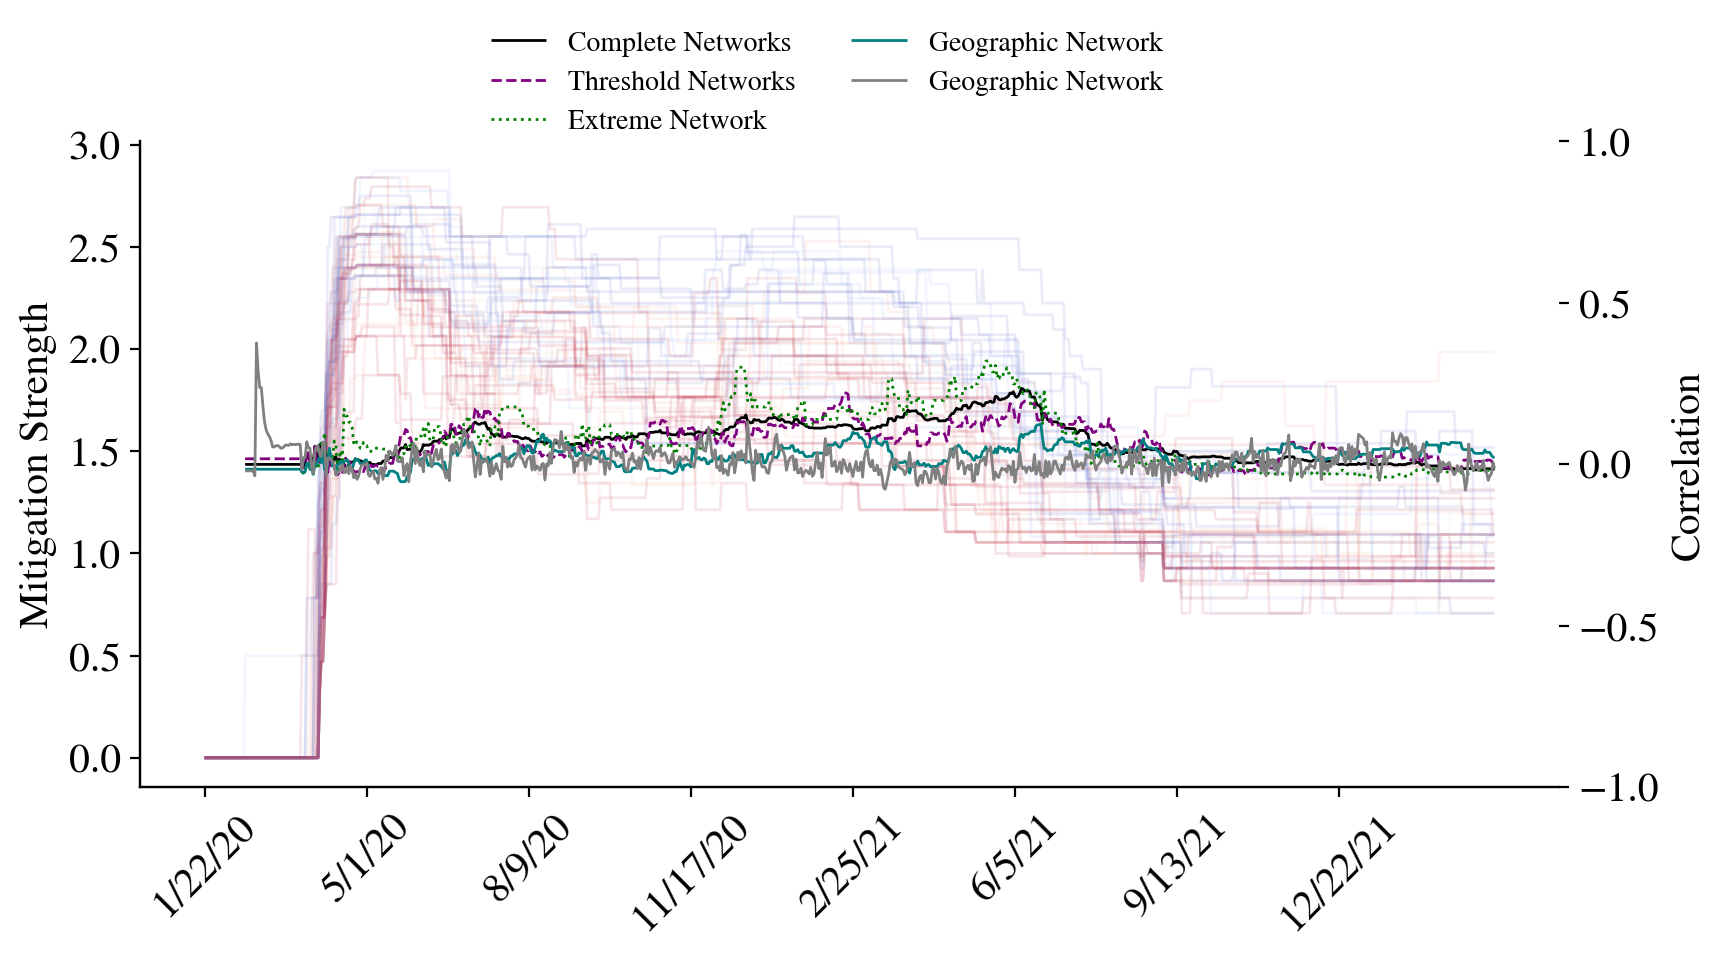

In [19]:
fig, ax = plt.subplots(figsize = (8,4))
fig.tight_layout(pad = 1)
for index in range(mitigation_array[:,:,-2].shape[0]):
    z = ax.plot(LA.norm(mitigation_array[index,:,:], axis = -1), linewidth = 1, alpha = 0.1, color = cm.coolwarm(poli_norm_color(-party_strength[index])))
    
# ax.plot(rep_norm/total_rep, 'r', label = 'Republican Mean', alpha = 0.5)
# ax.plot(dem_norm/total_dem, 'b', label = 'Democrat Mean', alpha = 0.5)

ax1 = ax.twinx()
ax1.plot(corr_full[:,0], 'k', lw = 1, label = 'Complete Networks')
ax1.plot(corr_binary[:,0], '--',color = 'purple', lw = 1, label = 'Threshold Networks')
ax1.plot(corr_1sd[:,0], ':', color = 'green', lw = 1, label = 'Extreme Network')
ax1.plot(corr_geo[:,0], '-', color = 'teal', lw = 1, label = 'Geographic Network')
ax1.plot(corr_inc[:,0], '-', color = 'grey', lw = 1, label = 'Geographic Network')
# ax1.plot(np.arange(0,mitigation_array.shape[1],7),corr_change[:,0], '-.', color = 'teal', lw = 1, label = 'Change')

ax1.set_ylim(-1,1)

# rep_mean = rep_norm/total_rep
# dem_mean = dem_norm/total_dem
# rep_var = np.var(total_norm[rep_list], axis = 0)
# dem_var = np.var(total_norm[dem_list], axis = 0)

ax.set_xticks(time[:-9][::100], dates[::100], rotation = 45)
ax.set_ylabel('Mitigation Strength')
ax1.set_ylabel('Correlation')
fig.legend(fontsize = 10, loc = 9, ncol = 2, bbox_to_anchor = (0.5,1.1))
# fig.suptitle('Mitigation Strength Correlation with Various Measures of Political Affilation', y = 1.16)



Text(0.5, 1.16, 'Mitigation Strength Correlation with Various Measures of Political Affilation')

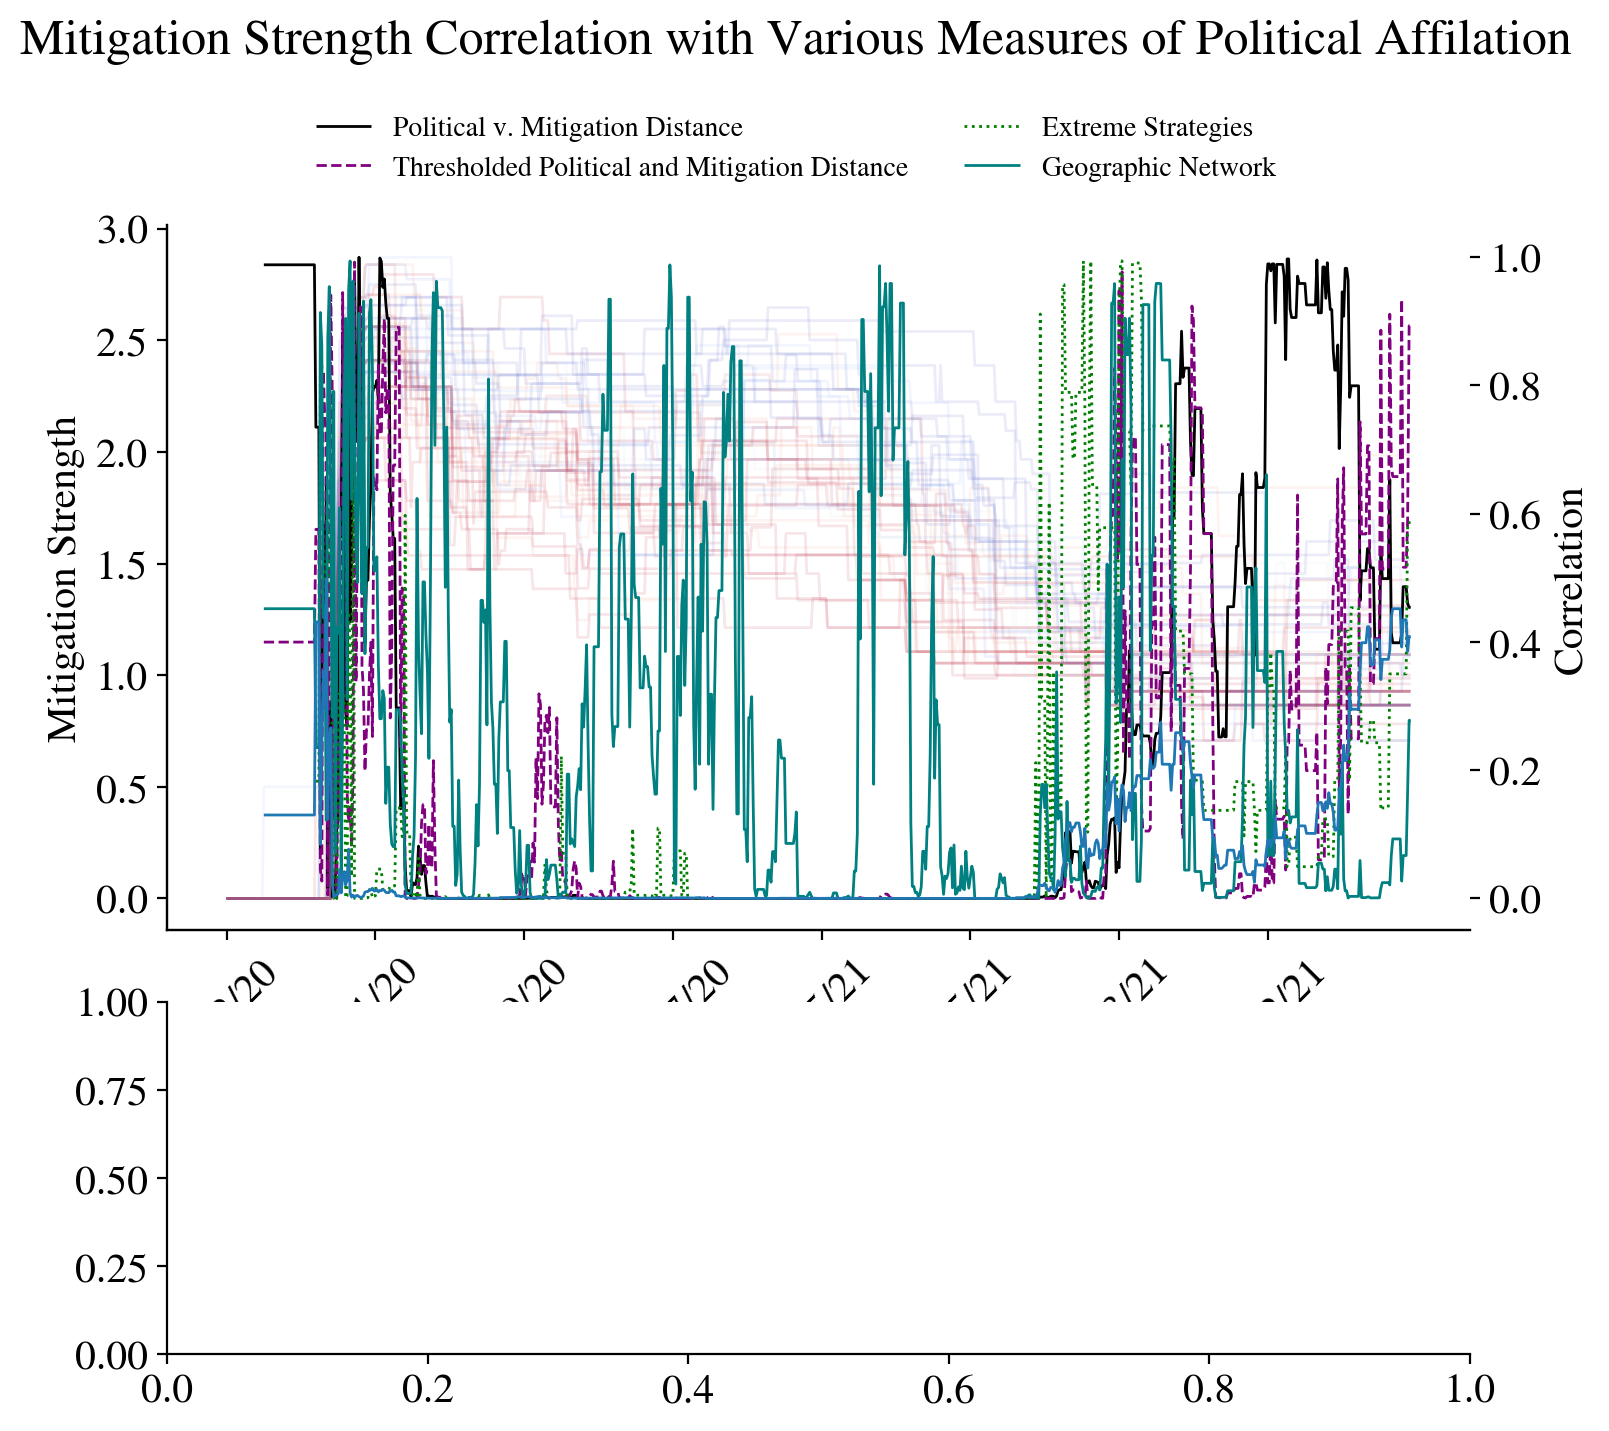

In [20]:
fig, (ax, ax2) = plt.subplots(2,1, figsize = (7,6), gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad = 0)
for index in range(mitigation_array[:,:,-2].shape[0]):
    z = ax.plot(LA.norm(mitigation_array[index,:,:], axis = -1), linewidth = 1, alpha = 0.1, color = cm.coolwarm(poli_norm_color(-party_strength[index])))
    
# ax.plot(rep_norm/total_rep, 'r', label = 'Republican Mean', alpha = 0.5)
# ax.plot(dem_norm/total_dem, 'b', label = 'Democrat Mean', alpha = 0.5)

ax1 = ax.twinx()
ax1.plot(corr_full[:,1], 'k', lw = 1, label = 'Political v. Mitigation Distance')
ax1.plot(corr_binary[:,1], '--',color = 'purple', lw = 1, label = 'Thresholded Political and Mitigation Distance')
ax1.plot(corr_1sd[:,1], ':', color = 'green', lw = 1, label = 'Extreme Strategies')
ax1.plot(corr_geo[:,1], '-', color = 'teal', lw = 1, label = 'Geographic Network')
ax1.plot(p, lw = 1)
# ax1.plot(np.arange(0, mitigation_array.shape[1], 7),corr_change[:,1], '-.', color = 'teal', lw = 1, label = 'Change', alpha = 1)

# ax1.set_ylim(-.1,.1)

rep_mean = rep_norm/total_rep
dem_mean = dem_norm/total_dem
rep_var = np.var(total_norm[rep_list], axis = 0)
dem_var = np.var(total_norm[dem_list], axis = 0)

ax.set_xticks(time[:-9][::100], dates[::100], rotation = 45)
ax.set_ylabel('Mitigation Strength')
ax1.set_ylabel('Correlation')
fig.legend(fontsize = 10, loc = 9, ncol = 2, bbox_to_anchor = (0.5,1.1))
fig.suptitle('Mitigation Strength Correlation with Various Measures of Political Affilation', y = 1.16)



In [21]:
sig_level = 0.01
sig_full = np.where(corr_full[:,1] < sig_level)[0]
sig_binary = np.where(corr_binary[:,1] < sig_level)[0]
sig_1sd = [i for i,v in enumerate(corr_1sd) if v[0] > 0 and v[1] < sig_level]
# sig_1sd = np.where((corr_1sd[:,1] < sig_level and corr_1sd[:,0] > 0))[0]
sig_geo = np.where(corr_geo[:,1] < sig_level)[0]
sig_inc = np.where(corr_inc[:,1] < sig_level)[0]


sig_full = [i for i,v in enumerate(corr_full) if v[0] > 0 and v[1] < sig_level]
sig_binary = [i for i,v in enumerate(corr_binary) if v[0] > 0 and v[1] < sig_level]
sig_1sd = [i for i,v in enumerate(corr_1sd) if v[0] > 0 and v[1] < sig_level]
sig_geo = [i for i,v in enumerate(corr_geo) if v[0] > 0 and v[1] < sig_level]
sig_inc = [i for i,v in enumerate(corr_inc) if v[0] > 0 and v[1] < sig_level]

(-25.0, 800.0)

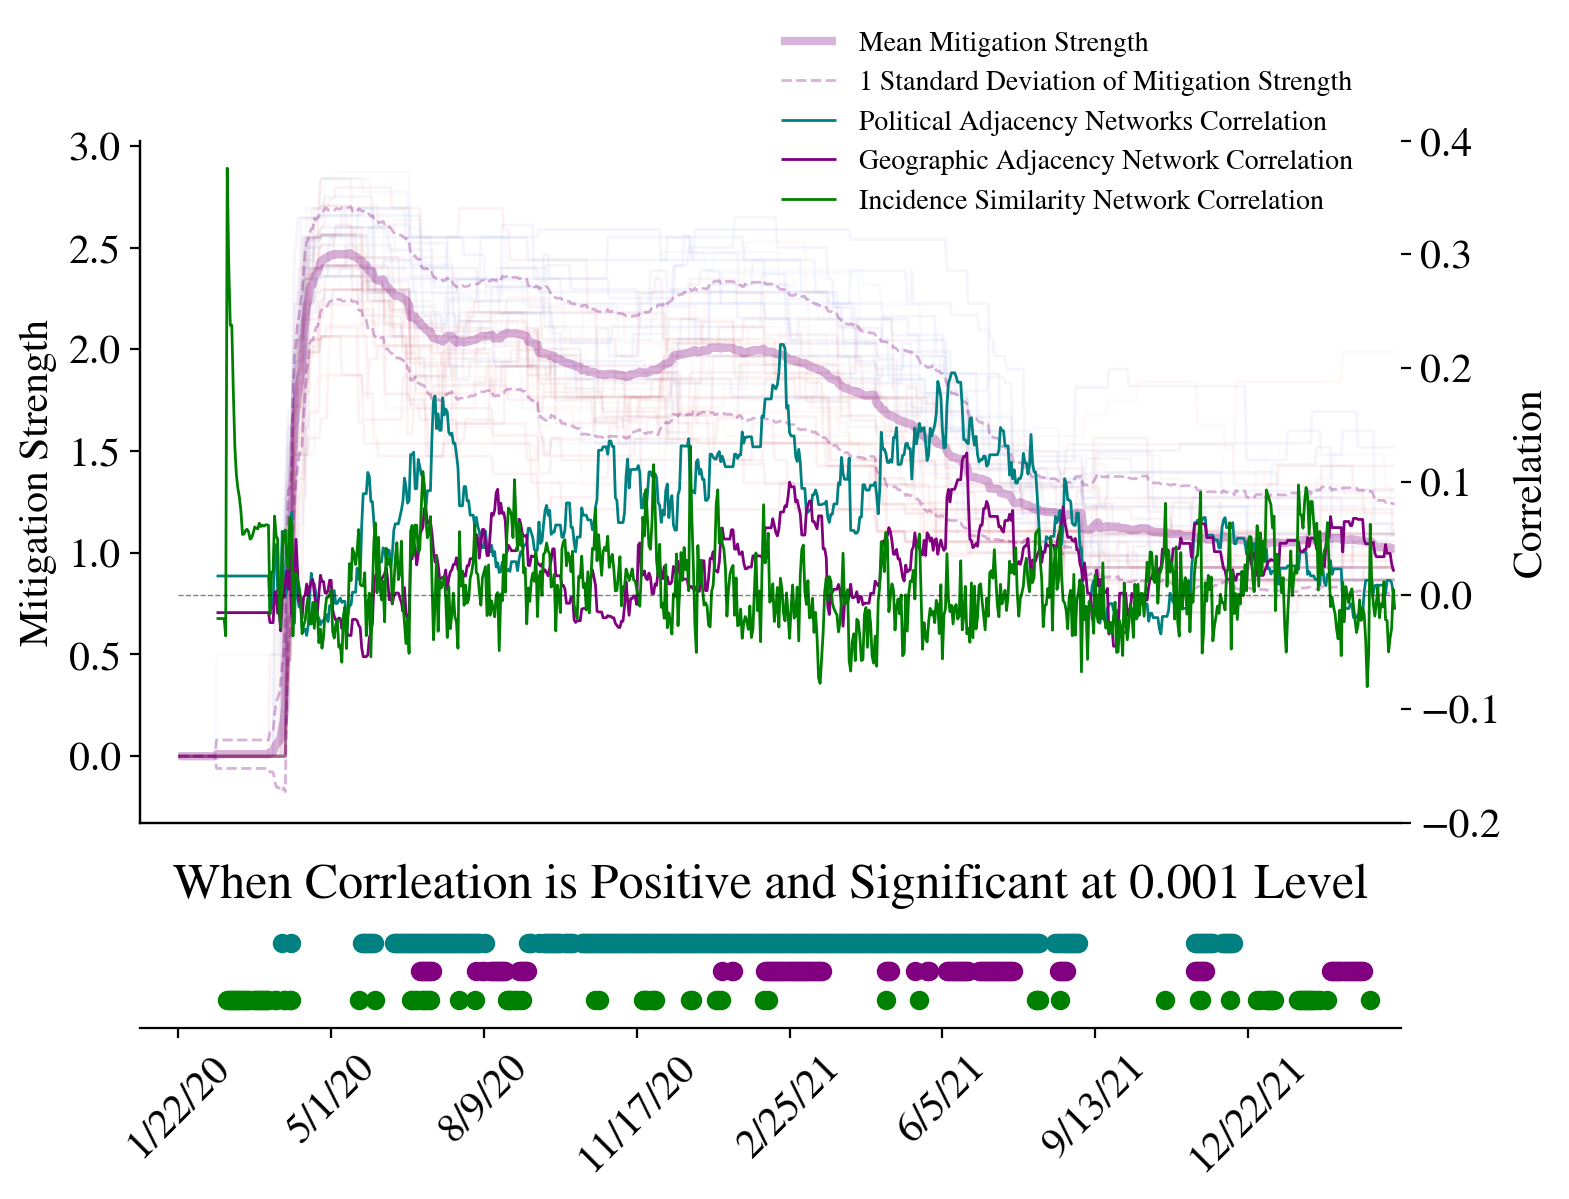

In [22]:
fig, (ax, ax2) = plt.subplots(2,1, figsize = (7,5), gridspec_kw={'height_ratios': [6, 1]})
fig.tight_layout(pad = 0.5)
for index in range(mitigation_array[:,:,-2].shape[0]):
    z = ax.plot(LA.norm(mitigation_array[index,:,:], axis = -1), linewidth = 1, alpha = 0.05, color = cm.coolwarm(poli_norm_color(-party_strength[index])))
    
# ax.plot(rep_norm/total_rep, 'r', label = 'Republican Mean', alpha = 0.5)
# ax.plot(dem_norm/total_dem, 'b', label = 'Democrat Mean', alpha = 0.5)
ax.plot(mean_list, 'purple', alpha = 0.3, label = 'Mean Mitigation Strength')
ax.plot(mean_list + np.sqrt(var_list), '--', color = 'purple', lw = 1, alpha = 0.3, label = '1 Standard Deviation of Mitigation Strength')
ax.plot(mean_list - np.sqrt(var_list), '--', color = 'purple', lw = 1, alpha = 0.3)

ax1 = ax.twinx()
# ax1.plot(corr_full[:,0], 'k', lw = 1, label = 'Political Distance Networks')
ax1.plot(corr_binary[:,0],color = 'teal', lw = 1, label = 'Political Adjacency Networks Correlation')
# ax1.plot(corr_1sd[:,0], color = 'green', lw = 1, label = 'Extreme Network')
ax1.plot(corr_geo[:,0], '-', color = 'purple', lw = 1, label = 'Geographic Adjacency Network Correlation')
ax1.plot(corr_inc[:,0], '-', color = 'g', lw = 1, label = 'Incidence Similarity Network Correlation')
# ax1.plot(np.arange(0,mitigation_array.shape[1],7),corr_change[:,0], '-.', color = 'teal', lw = 1, label = 'Change')

ax1.set_ylim(-0.2,0.4)

rep_mean = rep_norm/total_rep
dem_mean = dem_norm/total_dem
rep_var = np.var(total_norm[rep_list], axis = 0)
dem_var = np.var(total_norm[dem_list], axis = 0)

# ax.set_xticks(time[::100], dates[::100], rotation = 45)
ax.set_xticks([])
ax.set_ylabel('Mitigation Strength')
ax1.set_ylabel('Correlation')
fig.legend(fontsize = 10, ncol = 1, bbox_to_anchor = (0.95,1.1))
# fig.suptitle('Mitigation Strength Correlation with Potential Explanatory Factors', y = 1.16)

# ax2.scatter(sig_full, 2*np.ones(len(sig_full)), color = 'k')
ax2.scatter(sig_binary, 1*np.ones(len(sig_binary)), color = 'teal')
# ax2.scatter(sig_1sd, -2*np.ones(len(sig_1sd)), color = 'g')
ax2.scatter(sig_geo, 0*np.ones(len(sig_geo)), color = 'purple')
ax2.scatter(sig_inc, -1*np.ones(len(sig_inc)), color = 'g')
ax2.set_xticks(time[:-9][::100], dates[::100], rotation = 45)
ax2.set_yticks([])#[1,0,-1]) 
# ax2.set_yticklabels(['Complete Network', 'Threshold Network', 'Extreme Network'])
ax2.set_ylim(-2,2)
ax2.spines.left.set_color('white')
ax2.set_title('When Corrleation is Positive and Significant at 0.001 Level')
ax1.plot([0,975], [0,0], 'k--', alpha = 0.5, lw = 0.5)
ax.set_xlim(-25,800)
ax2.set_xlim(-25,800)

In [23]:
dates[-1]

'3/28/22'